In [1]:
!pip install yfinance
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [2]:
import statsmodels.api as sm
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.stattools import adfuller

# Data

## Data Preparation

In [3]:
portfolio1 = ['AMZN', 'GOOG', 'META', 'AAPL', 'NFLX']
portfolio2 = ['NVDA', 'AMD', 'SMCI']

In [50]:
df_tech = yf.download(portfolio1 , start='2019-04-01', end='2024-04-01')
df_chip = yf.download(portfolio2 , start='2019-04-01', end='2024-04-01')
df_nvidia = yf.download('NVDA' , start='2019-04-01', end='2024-04-01')

[*********************100%%**********************]  5 of 5 completed
[*********************100%%**********************]  3 of 3 completed
[*********************100%%**********************]  1 of 1 completed


In [5]:
df_tech['Close'].head()

Ticker,AAPL,AMZN,GOOG,META,NFLX
Date,,,,,
2019-04-01,47.810001,90.709503,59.721500,168.699997,366.959991
2019-04-02,48.505001,90.698997,60.024502,174.199997,367.720001
2019-04-03,48.837502,91.035004,60.296001,173.539993,369.750000
2019-04-04,48.922501,90.943001,60.750000,176.020004,367.880005
2019-04-05,49.250000,91.863998,60.357498,175.720001,365.489990


In [6]:
stock_tech = df_tech['Close']
fig = px.line(stock_tech)
fig.show()

In [7]:
stock_chip = df_chip['Close']
fig = px.line(stock_chip)
fig.show()

## Stationary Check

In order to pair data to the correct model, we need to test out the stationary of the data.

### Augmented Dickey-Fuller Test

To fit a non-stationary model, it is necessary yo comfirm all series of data have a unit root. The data's characteristic shows non-stationary at their origin time series data, but stationary at the first differences.

In [8]:
adf_results = []
for stock in df_tech['Close'].columns:
    adf = adfuller(df_tech['Close'][stock])
    crit_values = {key: value for key, value in adf[4].items()}
    adf_results.append({
        'Stock': stock,
        'ADF Statistic': adf[0],
        'p-value': adf[1],
        'n_lags': adf[2],
        'Critical Value (1%)': crit_values['1%'],
        'Critical Value (5%)': crit_values['5%'],
        'Critical Value (10%)': crit_values['10%']
    })
    print('the stock {} is {}stationary at level'.format(stock, 'not ' if adf[1] > 0.05 else '' ))
adf_results_df = pd.DataFrame(adf_results)
adf_results_df

the stock AAPL is not stationary at level
the stock AMZN is not stationary at level
the stock GOOG is not stationary at level
the stock META is not stationary at level
the stock NFLX is not stationary at level


,Stock,ADF Statistic,p-value,n_lags,Critical Value (1%),Critical Value (5%),Critical Value (10%)
0,AAPL,-1.624113,0.470574,0,-3.435563,-2.863842,-2.567996
1,AMZN,-1.550672,0.508312,0,-3.435563,-2.863842,-2.567996
2,GOOG,-1.078118,0.723719,0,-3.435563,-2.863842,-2.567996
3,META,0.012109,0.959522,1,-3.435567,-2.863844,-2.567997
4,NFLX,-1.285754,0.635665,0,-3.435563,-2.863842,-2.567996


In [9]:
adf_results = []
for stock in df_tech['Close'].columns:
    adf = adfuller(df_tech['Close'][stock].diff(periods = 1).dropna())
    crit_values = {key: value for key, value in adf[4].items()}
    adf_results.append({
        'Stock': stock,
        'ADF Statistic': adf[0],
        'p-value': adf[1],
        'n_lags': adf[2],
        'Critical Value (1%)': crit_values['1%'],
        'Critical Value (5%)': crit_values['5%'],
        'Critical Value (10%)': crit_values['10%']
    })
    print('the stock {} is {}stationary at level'.format(stock, 'not ' if adf[1] > 0.05 else '' ))
adf_results_df = pd.DataFrame(adf_results)
adf_results_df

the stock AAPL is stationary at level
the stock AMZN is stationary at level
the stock GOOG is stationary at level
the stock META is stationary at level
the stock NFLX is stationary at level


,Stock,ADF Statistic,p-value,n_lags,Critical Value (1%),Critical Value (5%),Critical Value (10%)
0,AAPL,-36.553466,0.0,0,-3.435567,-2.863844,-2.567997
1,AMZN,-36.201419,0.0,0,-3.435567,-2.863844,-2.567997
2,GOOG,-36.872664,0.0,0,-3.435567,-2.863844,-2.567997
3,META,-37.564657,0.0,0,-3.435567,-2.863844,-2.567997
4,NFLX,-36.289601,0.0,0,-3.435567,-2.863844,-2.567997


### Johansen Cointegration Test

In [10]:
coint_test_result = coint_johansen(df_tech['Close'], 0, 1)

In [11]:
data = {
    "Trace Statistics": [],
    "Critical Values (90%)": [],
    "Critical Values (95%)": [],
    "Critical Values (99%)": []
}
data["Trace Statistics"].append(coint_test_result.lr1)
data["Critical Values (90%)"].append(coint_test_result.cvt[0])  # Adjust indexes if needed
data["Critical Values (95%)"].append(coint_test_result.cvt[1])
data["Critical Values (99%)"].append(coint_test_result.cvt[2])

# Creating DataFrame
df = pd.DataFrame(data)
df

,Trace Statistics,Critical Values (90%),Critical Values (95%),Critical Values (99%)
0,"[41.14265527929574, 22.711119942424904, 10.231...","[65.8202, 69.8189, 77.8202]","[44.4929, 47.8545, 54.6815]","[27.0669, 29.7961, 35.4628]"


# Model

## Vector Auto-regression model

In [12]:
from statsmodels.tsa.vector_ar.var_model import VAR

In [13]:
data = df_tech['Close'].dropna()
data = data.asfreq('D', method='ffill')

In [14]:
train = data[:int(0.8*(len(data)))]
valid = data[int(0.8*(len(data))):]

In [15]:
train

Ticker,AAPL,AMZN,GOOG,META,NFLX
Date,,,,,
2019-04-01,47.810001,90.709503,59.721500,168.699997,366.959991
2019-04-02,48.505001,90.698997,60.024502,174.199997,367.720001
2019-04-03,48.837502,91.035004,60.296001,173.539993,369.750000
2019-04-04,48.922501,90.943001,60.750000,176.020004,367.880005
2019-04-05,49.250000,91.863998,60.357498,175.720001,365.489990
...,...,...,...,...,...
2023-03-25,160.250000,98.129997,106.059998,206.009995,328.390015
2023-03-26,160.250000,98.129997,106.059998,206.009995,328.390015
2023-03-27,158.279999,98.040001,103.059998,202.839996,327.660004


### Searching optimal order of VAR

In [16]:
model = VAR(endog = train)
aic = model.select_order(66)
aic.summary()

,AIC,BIC,FPE,HQIC
0,33.68,33.70,4.255e+14,33.69
1,9.922,10.03*,2.037e+04,9.964*
2,9.897,10.10,1.987e+04,9.974
3,9.889*,10.19,1.971e+04*,10.00
4,9.913,10.31,2.018e+04,10.06
5,9.935,10.42,2.065e+04,10.12
6,9.941,10.52,2.076e+04,10.16
7,9.947,10.62,2.088e+04,10.20
8,9.946,10.72,2.087e+04,10.23
9,9.938,10.80,2.071e+04,10.26


The AIC score hits the minimum when lag is 3. Thus, select 3 to forecast the model.

In [17]:
optimal = model.fit(maxlags =3)
optimal.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 12, Apr, 2024
Time:                     08:00:49
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                    10.0249
Nobs:                     1456.00    HQIC:                   9.84290
Log likelihood:          -17336.7    FPE:                    16892.1
AIC:                      9.73460    Det(Omega_mle):         15993.8
--------------------------------------------------------------------
Results for equation AAPL
             coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------
const           0.088660         0.231980            0.382           0.702
L1.AAPL         0.935683         0.038999           23.992           0.000
L1.AMZN         0.022860         0.034615            0.660           0.509
L1.GOOG   

In [18]:
lag = train.values[-3:]
forecast = optimal.forecast(y=lag, steps=len(valid))
forecast = pd.DataFrame(forecast, index=valid.index, columns=valid.columns + '_pred')
result = pd.concat([forecast,valid], axis=0)

In [19]:
fig = px.line(result)
fig.show()

### Evaluation

In [20]:
def calculate_error_metrics(actual, predicted):
    mae = np.mean(np.abs(predicted - actual))
    rmse = np.sqrt(np.mean((predicted - actual)**2))
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    return mae, rmse, mape

for i in valid.columns.tolist():
  actual = valid[i].values
  predicted = forecast[i+ '_pred'].values
  mae, rmse, mape = calculate_error_metrics(actual, predicted)

  print(i + f" MAE: {mae}, RMSE: {rmse}, MAPE: {mape}%")

AAPL MAE: 34.10248680272736, RMSE: 36.45860837140618, MAPE: 18.545802100840298%
AMZN MAE: 37.14333531638559, RMSE: 43.074536380379584, MAPE: 25.04451744160952%
GOOG MAE: 29.470433186688613, RMSE: 32.82744664916086, MAPE: 21.592728608411583%
META MAE: 162.77657255604524, RMSE: 186.4602193598465, MAPE: 45.986202178903376%
NFLX MAE: 154.22201922963578, RMSE: 181.85284121135325, MAPE: 31.835969427599515%


##  Vector Error Correction Model
To fit a VECM, it is required to determine the number of cointegrating relationships by VEC rank test.

In [21]:
from statsmodels.tsa.vector_ar.vecm import VECM
from statsmodels.tsa.vector_ar.vecm import select_coint_rank

In [22]:
data = df_tech['Close'].dropna()
data = data.asfreq('D', method='ffill')

In [23]:
train = data[:int(0.8*(len(data)))]
valid = data[int(0.8*(len(data))):]

In [24]:
vec_rank1 = select_coint_rank(train, det_order = 1, k_ar_diff = 1, method = 'trace', signif=0.01)
vec_rank1.summary()

r_0,r_1,test statistic,critical value
0,5,56.99,87.77


The test statistic of 56.99 is lower than the critical value 87.77 and so the null of at most one co-integrating vector cannot be rejected.

In [25]:
vec_rank2 = select_coint_rank(train, det_order = 1, k_ar_diff = 1, method = 'maxeig', signif=0.01)
vec_rank2.summary()

r_0,r_1,test statistic,critical value
0,1,28.21,42.86


In [26]:
vecm = VECM(endog = train, k_ar_diff = 9, coint_rank = 3, deterministic = 'ci')
vecm_fit = vecm.fit()
vecm_fit.predict(steps=len(valid))

array([[160.34737706,  99.73710605, 101.66311779, 205.26899874,
        331.35721674],
       [159.27174352,  99.07967438, 101.23906386, 201.36351246,
        327.79862664],
       [159.589821  , 100.33440965, 101.68784425, 200.50106321,
        329.00090962],
       ...,
       [165.00326777, 110.4065132 , 114.61949179, 177.08054699,
        339.05653968],
       [165.00832396, 110.39300355, 114.62139658, 177.0468135 ,
        338.98924348],
       [165.01334465, 110.37946079, 114.62325236, 177.01303656,
        338.92198424]])

In [27]:
forecast, lower, upper = vecm_fit.predict(len(valid), 0.05)

In [28]:
df_forecast = pd.DataFrame(forecast, columns=['AMZN', 'GOOG', 'META', 'AAPL', 'NFLX'])
df_lower = pd.DataFrame(lower, columns=['AMZN', 'GOOG', 'META', 'AAPL', 'NFLX'])
df_upper = pd.DataFrame(upper, columns=['AMZN', 'GOOG', 'META', 'AAPL', 'NFLX'])

In [29]:
forecast = pd.DataFrame(forecast, index=valid.index, columns=valid.columns + '_pred')
result = pd.concat([forecast,valid], axis=0)
fig = px.line(result)
fig.show()

## LSTM


In [42]:
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Flatten
import tensorflow as tf

In [73]:
def Lstm_model(X,y):
    model=Sequential()

    model.add(LSTM(20,return_sequences=True,input_shape=(X.shape[1], X.shape[2])))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    #model.add(LSTM(15,return_sequences=True))
    #model.add(Dropout(0.2))
    #model.add(BatchNormalization())
    model.add(LSTM(15))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1))

    adam = optimizers.Adam(0.001)
    model.compile(loss='mean_squared_error',optimizer=adam)

    es = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=15, restore_best_weights=True)
    model.fit(X, y,validation_split=0.2,epochs=100,batch_size=64,verbose=1, callbacks=[es])
    return model

In [67]:
from sklearn.preprocessing import StandardScaler

In [68]:
Scale=StandardScaler()
def data_prep(df, lookback, future, Scale):
    date_train=pd.to_datetime(df.index)
    df_train=df[['Open','High','Low','Close','Volume']]
    df_train=df_train.astype(float)
    df_train_scaled=Scale.fit_transform(df_train)
    X, y =[],[]
    for i in range(lookback, len(df_train_scaled)-future+1):
        X.append(df_train_scaled[i-lookback:i, 0:df_train.shape[1]])
        y.append(df_train_scaled[i+future-1:i+future, 0])

    return np.array(X), np.array(y), df_train, date_train

Lstm_x, Lstm_y, df_train, date_train = data_prep(df_nvidia, 30, 1, Scale)

In [69]:
def predict_close(model,date_train,Lstm_x,df_train, future, Scale):
    forecasting_dates=pd.date_range(list(date_train)[-1], periods=future, freq='1d').tolist()
    predicted=model.predict(Lstm_x[-future:])
    predicted1=np.repeat(predicted, df_train.shape[1], axis=-1)
    predicted_descaled=Scale.inverse_transform(predicted1)[:,0]
    return predicted_descaled,forecasting_dates

def output_prep(forecasting_dates,predicted_descaled):
    dates=[]
    for i in forecasting_dates:
        dates.append(i.date())
    df_final=pd.DataFrame(columns=['Date','Close'])
    df_final['Date']=pd.to_datetime(dates)
    df_final['Close']=predicted_descaled
    return df_final

In [70]:
def results(df, lookback, future, Scale, x):
    Lstm_x, Lstm_y, df_train, date_train = data_prep(df, lookback, future, Scale)
    model=Lstm_model(Lstm_x,Lstm_y)
    loss=pd.DataFrame(model.history.history)
    loss.plot()
    future=30
    predicted_descaled,forecasting_dates=predict_close(model,date_train,Lstm_x,df_train,future, Scale)
    results=output_prep(forecasting_dates,predicted_descaled)
    print(results.head())
    plt.show()
    fig = px.area(results, x="Date", y="Close", title=x)
    fig.update_yaxes(range=[results.Close.min()-10, results.Close.max()+10])
    fig.show()

Epoch 1/100
16/16 [==============================] - 7s 121ms/step - loss: 0.3232 - val_loss: 3.8204
Epoch 2/100
16/16 [==============================] - 1s 33ms/step - loss: 0.1566 - val_loss: 3.7189
Epoch 3/100
16/16 [==============================] - 1s 33ms/step - loss: 0.1138 - val_loss: 3.6093
Epoch 4/100
16/16 [==============================] - 1s 32ms/step - loss: 0.0876 - val_loss: 3.5052
Epoch 5/100
16/16 [==============================] - 1s 33ms/step - loss: 0.0749 - val_loss: 3.4336
Epoch 6/100
16/16 [==============================] - 1s 32ms/step - loss: 0.0586 - val_loss: 3.2910
Epoch 7/100
16/16 [==============================] - 1s 33ms/step - loss: 0.0551 - val_loss: 3.2733
Epoch 8/100
16/16 [==============================] - 1s 32ms/step - loss: 0.0494 - val_loss: 3.1292
Epoch 9/100
16/16 [==============================] - 1s 33ms/step - loss: 0.0449 - val_loss: 3.1112
Epoch 10/100
16/16 [==============================] - 1s 32ms/step - loss: 0.0379 - val_loss: 2.955

1/1 [==============================] - 1s 888ms/step
        Date       Close
0 2024-03-28  303.744843
1 2024-03-29  301.872986
2 2024-03-30  300.274017
3 2024-03-31  300.307220
4 2024-04-01  301.619324


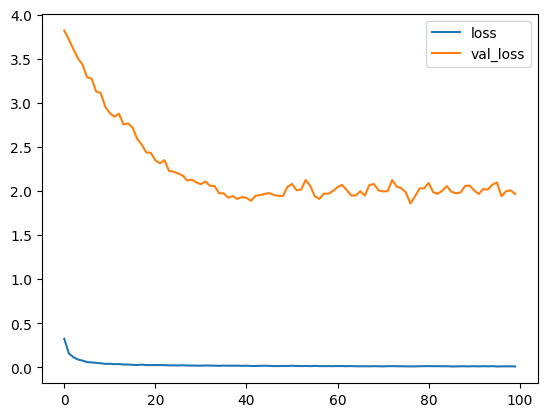

In [74]:
results(df_nvidia, 30, 1, Scale, 'Nvidia')